# Model Building<br/>*Hyperparameter Optimization*

## Goals
1. Optimize Hyperparameter for Regularization
2. Account for no final hold-out set
4. Create and analyze the Learning Curve
5. Compare new model to previous model

For an another discussion of the topics present in this and previous notebooks, see: [Model Selection](https://towardsdatascience.com/a-short-introduction-to-model-selection-bb1bb9c73376)

## Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


## Recreate Model from Previous Iteration

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [4]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)
cv_select_quick = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=108)

In [5]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.814 max:0.850
CV Mean Score: 0.830 +/- 0.013


The model from the previous iteration has been recreated.

## Preferred Method to<br/>Optimize Hyperparameters *And*<br/> Evaluate Performance of Optimized Model

Cross Validation cannot be used to *both* find the best hyperparameters *and* provide an accurate estimate of model performance.  In hyperparameter optimization, the CV test folds are used over and over again.  These test folds become data used as part of the model building process resulting in an overly optimistic estimate of model performance.

The preferred method to find the best model and estimate its performance on unseen data is:
* set aside a final hold-out test set to be used at the end of the project only
* use cross validation on the remaining data to:
  * to select the best hyperparameters
  * to experiment with the best features to extract
  * to experiment with the best data transformations
* having decided on the best way to build a model, build it on all the data except the final hold-out set
* evaluate this model on the final hold-out set

### Caveat: Don't Use Final Hold-Out Set for Very Small Data Sets
The Titanic data set from Kaggle has 891 labeled records.

Example 1:
* train: 80%, test: 20%
* 2-Fold CV on train => .8 * .5 * 891 = 356 records to train on
* 2-Fold CV on validation => .8 * .5 * 891 = 356 records to validate hyperparameters on
* final scoring on .2 * 891 = 178 records
This is too few records to train on and too few records for get a test score with low variance.

Example 2:
* train: 80%, test: 20%
* 5-Fold CV on train => .8 * .8 * 891 = 570 records to train on
* 5-Fold CV on validation => .8 * .2 * 891 = 143 records to validate hyperparameters on
* final scoring on .2 * 891 = 178 records
This is too few records to validate the hyperparameters on with a low enough variance to be sure that the best hyperparameters were chosen.  As before, this is also too few records to get a test score with low variance.

A final hold-out test set does not work well for a data set this small.

For small data sets, there are two other approaches that can be taken:
* the "one-standard-error" rule
* nested cross validation

The one-standard-error rule provides useful insights into the model building process.  
Nested Cross Validation provides the best estimate of model performance available for a small data set.

### One Standard Error Rule
The complexity of the model is reduced until a score 1 standard error below the optimal score is found.  This reduced complexity model can be used as the model to deploy.

The rational is that simpler models tend to do better in practice.  This is often referred to as Occam's Razor or the principle of parsimony.  If the simpler model has a score within 1 standard deviation of the best model, then arguably its score is the same, so use the simpler model.

This is described in section 6.1 of [ISLR](http://www-bcf.usc.edu/~gareth/ISL/) or section 7.3 of [ESL](https://web.stanford.edu/~hastie/ElemStatLearn/).

As per [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) smaller values of C specify stronger regularization (i.e. reduced model complexity).

In [6]:
c_values = np.logspace(-2,1)
results = []
for c in c_values:
    
    lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    pipe = Pipeline([('ct', ct), ('lr', lr)])

    scores = cross_val_score(pipe, X, y, cv=cv_select, 
                             scoring='accuracy')
    
    results.append((c, scores.mean(), scores.std()))

In [7]:
df = pd.DataFrame(data=results, columns=['C', 'Score', 'SD'])
df.head()

,C,Score,SD
0,0.010000,0.808544,0.020419
1,0.011514,0.812356,0.019376
2,0.013257,0.816392,0.017005
3,0.015264,0.818970,0.014662
4,0.017575,0.820877,0.015444


In [8]:
i_max = df['Score'].idxmax()
print('Best Score')
print(df.iloc[i_max])

Best Score
C        2.811769
Score    0.831649
SD       0.013843
Name: 40, dtype: float64


In [9]:
# low end of CI for highest Score
best_low = df.iloc[i_max]['Score'] - df.iloc[i_max]['SD']

# decrease C (which increases regularization) to find C
for i in range(i_max, -1, -1):
    if df.loc[i]['Score'] >= best_low:
        i_min = i
    else:
        break
print('Score: 1 SE Less')
print(df.loc[i_min])

# midpoint = (df.loc[i_min]['high'] + df.loc[i_max]['low']) / 2

Score: 1 SE Less
C        0.015264
Score    0.818970
SD       0.014662
Name: 3, dtype: float64


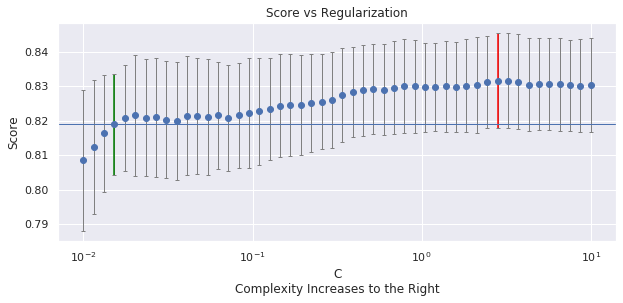

In [10]:
# plot the mean scores and their standard error vs C
fig = plt.figure(figsize=[10,4])

plt.errorbar(df['C'], df['Score'], yerr=df['SD'], 
             ecolor='gray', elinewidth=1, 
             fmt='o', capsize=2);
# Best
plt.errorbar(df['C'].iloc[i_max], df['Score'].iloc[i_max], 
             yerr=df['SD'].iloc[i_max], ecolor='red')
# 1 SE Less
plt.errorbar(df['C'].iloc[i_min], df['Score'].iloc[i_min], 
             yerr=df['SD'].iloc[i_min], ecolor='green')

ax = plt.gca()
ax.set_xscale('log')
plt.axhline(df['Score'].iloc[i_min], linewidth=1)
plt.xlabel('C\nComplexity Increases to the Right')
plt.ylabel('Score');
plt.title('Score vs Regularization');

The optimal value of C was found, and then C was lowered until the mean score just barely fell within the confidence interval of the optimal score.

The higher level of regularization results in a simpler model that is less likely to overfit the data.

Regularization reduces the degrees of freedom, which is similar to reducing the number of variables, except that it does so gradually.  L2 regularization is generally believed to allow for the best predictions.  L1 regularization can force a coefficient to zero, removing the variable entirely, which may allow for better interpretability.

The simpler model with a mean score of .819 seems worse than model with a mean score of .832, but as the simpler one is within the confidence interval of the best, they represent effectively the same score.

**Summary of One-Standard-Error**  
Without having a final hold-out set, there was no way to know if the hyperparameter optimized model overfit the data.  By backing off one-standard-error, with respect to tuning the hyperparameter for complexity, a simpler model was created with similar performance but less chance of overfit.

### Custom Learning Curve: Best K for Ranking Models
The Learning Curve helper function in Scikit Learn doesn't compute the variance of the estimate of the model performance at various training set sizes.

As the goal is to find which value for K allows for best ranking of models, it is critical to know the variance.

In [11]:
c_simple = df['C'].iloc[i_max]
c_best = df['C'].iloc[i_min-1]

lr_simple = LogisticRegression(penalty='l2', C=c_simple, 
                               solver='liblinear')
lr_best = LogisticRegression(penalty='l2', C=c_best, 
                             solver='liblinear')

pipe_simple = Pipeline([('ct', ct), ('lr_simple', lr_simple)])
pipe_best = Pipeline([('ct', ct), ('lr_best', lr_best)])

In [12]:
# use repeated CV to reduce the variance
results = []
for k in range(2, 11):
    cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=10, random_state=108)
    scores_simple = cross_val_score(pipe_simple, X, y, cv=cv)
    scores_best = cross_val_score(pipe_best, X, y, cv=cv)
    
    results.append((k, scores_simple.mean(), scores_simple.std(), 
                   scores_best.mean(), scores_best.std()))
    
df_results = pd.DataFrame(results, 
                          columns=['k', 'simple_mean', 'simple_me',
                                   'best_mean', 'best_me'])    

In [13]:
df_results.head()

,k,simple_mean,simple_me,best_mean,best_me
0,2,0.831649,0.013843,0.816392,0.017005
1,3,0.833109,0.017029,0.821886,0.016085
2,4,0.833664,0.023281,0.824467,0.024980
3,5,0.835131,0.023130,0.825589,0.027595
4,6,0.835125,0.024860,0.825808,0.027074


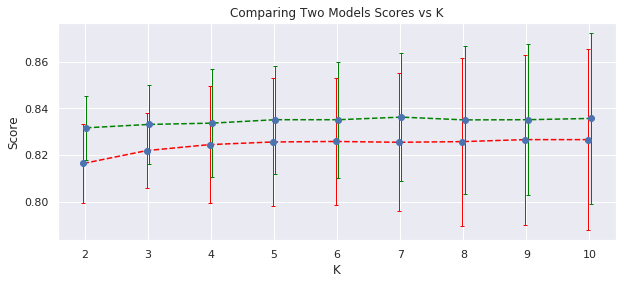

In [14]:
df2 = df_results

# plot the mean scores and their standard error vs C
fig = plt.figure(figsize=[10,4])

jitter = 0.02

# 1 SE Less
plt.errorbar(df2['k']+jitter, df2['simple_mean'], yerr=df2['simple_me'], 
             elinewidth=1, 
             fmt='o', capsize=2, ecolor='green');

plt.errorbar(df2['k']-jitter, df2['best_mean'], yerr=df2['best_me'], 
             elinewidth=1, 
             fmt='o', capsize=2, ecolor='red');

plt.plot(df2['k']+jitter, df2['simple_mean'], linestyle='--', 
         color='green')

plt.plot(df2['k']-jitter, df2['best_mean'], linestyle='--', 
         color='red')

ax = plt.gca()
plt.xlabel('K')
plt.ylabel('Score');
plt.title("Comparing Two Models Scores vs K");

In looks like K=5 allows for enough training data to provide an unbiased estimate of model preformance.  For a clearer plot, replot the above from K=2 to K=5.

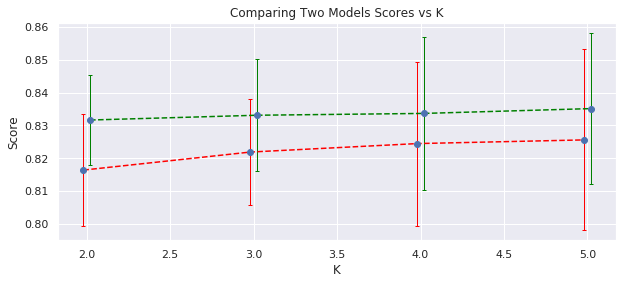

In [15]:
df2 = df_results[:4]

# plot the mean scores and their standard error vs C
fig = plt.figure(figsize=[10,4])

jitter = 0.02

# 1 SE Less
plt.errorbar(df2['k']+jitter, df2['simple_mean'], yerr=df2['simple_me'], 
             elinewidth=1, 
             fmt='o', capsize=2, ecolor='green');

plt.errorbar(df2['k']-jitter, df2['best_mean'], yerr=df2['best_me'], 
             elinewidth=1, 
             fmt='o', capsize=2, ecolor='red');

plt.plot(df2['k']+jitter, df2['simple_mean'], linestyle='--', 
         color='green')

plt.plot(df2['k']-jitter, df2['best_mean'], linestyle='--', 
         color='red')

ax = plt.gca()
plt.xlabel('K')
plt.ylabel('Score');
plt.title("Comparing Two Models Scores vs K");

### Custom Learning Curve: Analysis

At K=2, both the red (1 SE simpler) and the green (optimized) model scores are distinguishable.  The score of the simpler model does not fall within the confidence interval of the optimized model.

It is apparent that both models have a slightly pessimisticaly biased score at K=2, as the score is larger for higher K, which allows for more data to train on.

However at K > 2, the confidence intervals get wider as there is less data available for scoring the models on.  This makes distinguishing one model from the other increasingly difficult.

The above shows that K=2 is better than K=5 (or K=10) for ranking which model is best.

Somewhere between K=3 and K=5 appears to allow for sufficient training data to produce an unbiased score.  With 891 records, this corresponds to about 600 or 700 records to train on to reach model capacity.

### Nested Cross Validation Description
Nested Cross Validation requires significantly more computation time than regular CV, but is only needed when there is a small amount of data.

Nested Cross Validation works by embedding GridSearchCV inside of cross_val_score.  This puts the entire model building process inside of cross validation, ensuring that the entire model building process is being properly evaluated.

Often K=2 is chosen for the inner CV (which performs model selection) and K=5 is chosen for the outer CV (which performs model evaluation).

#### Nested CV Code Preparation

In [16]:
# First: Verify that non-nested GridSearchCV gives same result 
# as above

# Parameters to optimize over
p_grid = {"lr__C": np.logspace(-2,1)}

lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

grid = GridSearchCV(estimator=pipe, param_grid=p_grid, 
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [17]:
# Copied from titanic_helper_code.py
def print_grid(grid, pandas=False):
    """Print Best and Return Results in a DataFrame"""

    std = grid.cv_results_['std_test_score'][grid.best_index_]
    print(f'Best: {grid.best_score_:0.3f} +/- {std:0.3f}')
    for key, value in grid.best_params_.items():
        print(f'{key}: {value}')

    if pandas:
        results = []
        for i in range(len(grid.cv_results_['mean_test_score'])):
            score = grid.cv_results_['mean_test_score'][i]
            std = grid.cv_results_['std_test_score'][i]
            params = grid.cv_results_['params'][i]
            params['score'] = score
            params['std'] = std
            results.append(params)

        return pd.DataFrame(results)

In [18]:
# verify the GridSearchCV scores are the same as computed with
# the above for-loop (within a relative tolerance of .0001)
df2 = tt.print_grid(grid, pandas=True)
print()
print(f'Same Scores: {np.isclose(df2["score"], df["Score"], rtol=1e-4).all()}')

Best: 0.832 +/- 0.014
lr__C: 2.8117686979742307

Same Scores: True


This are the same values as in the above for-loop.

#### Nested CV Code
Now encapsulate GridSearchCV itself inside of cross validation.  This ensures that the model building process is fully within cross validation.

Note this works because by default refit=True.  This means the model used for prediction inside of cross validation is the model fitted with the best parameters found on that test fold.

In the following, the outer evaluation loop has K=3 as this allows enough training records to reach near full capacity will reducing the variance on the score.  The inner loop for model selection uses K=2 as before.  Both are repeated 10 times.  The total number of evaluations is: 10\*2\*10\*3 = 600.

In [21]:
# same as above, except:
# use cv_select (10 repeats vs 5 to reduce variance)
# cv_eval with K=3 (very small bias with this dataset, further reduces variance)
# cv_eval with 10 repeats instead of 5, to further reduce variance
cv_eval = RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=1001)

p_grid = {"lr__C": np.logspace(-2,1)}
lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

grid = GridSearchCV(estimator=pipe, param_grid=p_grid, 
                    scoring='accuracy', cv=cv_select)

scores = cross_val_score(grid, X, y, scoring='accuracy', cv=cv_eval)
tt.print_scores(scores)

30 Scores  min:0.798 max:0.882
CV Mean Score: 0.831 +/- 0.021


The Nested CV estimate of model performance is: 0.831 +/- 0.021.

This is virtually the same as the non-nested 10-Repeated 2-Fold CV estimate of 0.832 +/- 0.014 using the best value for C.

In [22]:
# Read scores from 4th iteration
prev_scores = np.load('./data/iter04.data.npy')
print(f'Previous CV Mean Score: {prev_scores.mean():.3f} +/- {prev_scores.std():.3f}')

Previous CV Mean Score: 0.830 +/- 0.013


The previous iteration's score is effectively the same as the nested CV score for the hyperparameter optimized model.  As such, optimizing C did not improve the model.  The default regularization parameter was good.

### Notebook Summary

* hyperparameter for regularization was optimized
* one-standard-error rule was used to find a simpler model
* a custom learning curve was created to show that K=2 is the best
value for K for ranking models
* nested CV's estimate of model performance, for this model, was essentially the same as the non-optimized model

The Titanic data set is rather simple and small.  This is about as much as can be done with it using LogisticRegression.

In the next notebook, different estimators will be tried, and they will be combined with Stacking to see if a better result is possible.